# Group By and Aggregate Operations

In [ ]:
import pandas as pd
import numpy as np

This is a dataset that involves a lot of data across many datatypes, and we'll use it to aggregate data into different sets using the `.groupby()` method

In [ ]:
data = pd.read_csv(r'./Admissions_to_DMHAS_Addiction_Treatment_by_Town__Year__Month__and_Primary_Drug.csv')

Looking at the columns here, we can see some numbers (as floats), dates, and strings.

In [ ]:
data.head()

Up until now, we've been using masking, boolean logic, and methods to arrive at some conclusions. Let's look at this one:

In [ ]:
data[(data['PrimaryDrug'] == "Alcohol") & (data['AdmCount'].notnull())]['AdmCount'].sum()

But, using the `.groupby()` method and an aggregate function we can look at a whole host of data very quickly (and simply).

In [ ]:
data['AdmCount'].groupby(data['PrimaryDrug']).sum()

Grouping by various characteristics and then applying an operation allows for some previews of data, provided it isn't _messy_. Let's look at some of the information we have:

In [ ]:
data['Town'].value_counts()

Here, we're just seeing all of the values associated with each town. Let's look at one of the lower numbers to see if we can figure out what this number is telling us.

In [ ]:
data[data['Town']=='Wilton']

The town of Wilton has 15 rows, but our value for most of the rows under AdmCount is NaN. Depending on our analysis, this takes up a lot of space. This is informative, but from a presentation point of view, it may be unnecessarily cumbersome. Look at one of the towns near the top of the first list, Hartford:

In [ ]:
data[data['Town']=='Hartford']

'Hartford' too is cumbersome, but for a different reason - there's a lot of _actual_ data.

The `.groupby()` method allows us to take rows of data; separate them from each other; find a characteristic (or multiple characteristics); perform an aggregate function to represent each of these groups; and return results based upon that calculation.

Let's look at the pile of shapes below.

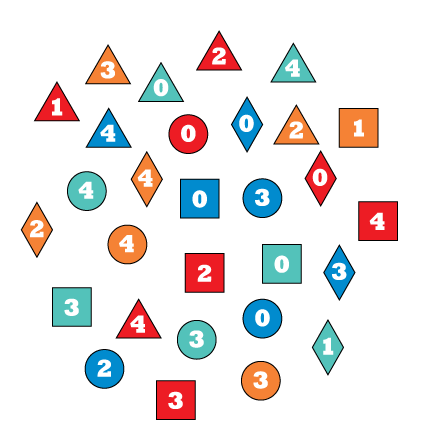

There's a lot of information here, but it's scattered. How about organizing it in some way.

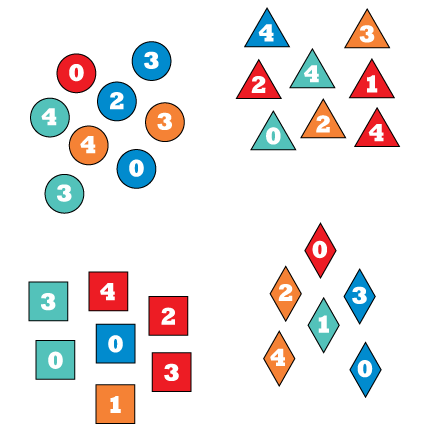

Here we're grouping by shape. From here, we could use `.size()` to count the items in each group. Or, we could `.sum()` the values, or get the `.mean()`.

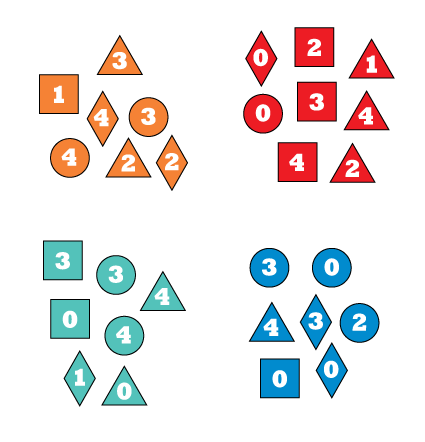

Or, we could group by color. We'd still have the same operations available to us, but we're _grouping_ on a different characteristic. Ultimately, we're looking for criteria that separates our data into groups, and then deciding on a method to provide a single value to represent each group in the returned table.

Looking at our data, let's apply something to a group. How about the total number of admissions per town.

In [ ]:
data.groupby(data['Town']).sum().loc[:,'AdmCount'].sort_values(ascending=False)

We can even group by multiple criteria, by passing a list to the `.groupby()` method.

In [ ]:
data.groupby(['Town','FiscalYear']).sum().loc[:,'AdmCount']

Or, we can have multiple criteria on both sides of the group. In this one, we're using a row indexer to isolate our report to a single town. Note: if you want to see the data for a single row criteria, make sure that row's column is listed in the groupby method. Below, we want to see all of the admissions for 'Hartford' by year, so, we have to group by town.

In [ ]:
data.groupby(['Town','FiscalYear','PrimaryDrug']).sum().loc['Hartford','AdmCount']

Grouping is dependent on the 'grouped' criteria being _exactly_ the same. When the data is clean, it works very well. However, what if a few entries are different? It's reasonable that the entry **Hallucinogens: LSD, DMS, STP, etc** could have been input with or without the examples. Or, the examples could have been ordered in a different way. How can we _programmatically_ handle this situation? Fuzzy Text Matching!

### Fuzzy Text Matching

Below, we're importing two new libraries. But, they're picky, so we're going to step out for a moment and do a separate install. 

In [ ]:
#!pip install fuzzywuzzy[speedup]
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

Fuzzywuzzy is a library that uses string parsing and comparison methods to score a relation between two strings. 'Fuzz' deals with a comparison between two different strings, and 'Process' works with comparing a single item to a list.

`.ratio()` compares two strings based upon their ratio of similarity using the difflib python library. It works really  well to determine whether or not two strings are close, or exactly the same.

In [ ]:
fuzz.ratio("I love parsing data","I love parsing datas")

In [ ]:
fuzz.ratio("Welcome to Raleigh!","Welcome to NCSU!")

Fuzzy Text Matching isn't perfect, so the creators of Fuzzywuzzy have a number of ratio functions that help with situations where strings have varying levels of overlapping elements.

In [ ]:
# works best when one is a substring of the other.
print(fuzz.partial_ratio("Welcome to Data Matters Messy Data!","Messy Data!"))

# works best when strings have similar content, but different order.
print(fuzz.token_sort_ratio("Data Matters Messy Data","Messy Data Data Matters"))

# isolates the intersection, and compares the remainder.
print(fuzz.token_set_ratio("Welcome to Data Matters Messy Data","Welcome to Messy Data") )

Now, let's use process to comparing an element to a list of items:

In [ ]:
fruit = ["Apple","Banana","Orange","Strawberry","Raspberry","Blueberry"]

In [ ]:
process.extract("apple",fruit)

In [ ]:
process.extract("snapple",fruit)

In [ ]:
process.extractOne("carrot",fruit)

In [ ]:
# process.dedupe?

So how does this help us with messy data? Well, what if someone inputting the data in on of our rows chooses to change the way they order the descriptors. Using the example before, "Hallucinogens: LSD, DMS, STP, etc" could be "Hallucinogens: DMS, LSD, STP, etc". They look the same to us, but to a computer, they're vastly different. I'll break that in one place to make a point: (note: check out how I tricked the indexer...)

In [ ]:
data.loc[data.index[2469],'PrimaryDrug']

I've reordered the words here. Still legitimate to human eyes, but look at what it does to our report.

In [ ]:
data.loc[data.index[2469],'PrimaryDrug'] = "Hallucinogens: DMS, LSD, STP, etc"

In [ ]:
data.groupby(['Town','PrimaryDrug']).sum().loc['Hartford','AdmCount']

Let's start by making a list of our valid entries. We'll take all of the unique values (including our incorrect one) and assign it to a list.

In [ ]:
correct_list = list(np.unique(data['PrimaryDrug']))
correct_list

We can see that there are two entries that are very similar. 
Now, let's look at the comparison between the unwanted entry, and the list:

In [ ]:
incorrect_item = "Hallucinogens: DMS, LSD, STP, etc"
correct_list.remove(incorrect_item)

In [ ]:
correct_list

Here we're using `process.extract()` to see the top (default five) entries that match our incorrect item, and the scores.

In [ ]:
process.extract(incorrect_item,correct_list)

The function returns a tuple, and we take the first (zero-indexed) item, the string.

In [ ]:
process.extractOne(incorrect_item,correct_list)[0]

Using this functionality, let's define a function that will replace incorrect values with correct ones:

In [ ]:
def fuzzyFix(value,list,threshold):
    if value in list:
        return value
    elif process.extractOne(value,list)[1] > threshold:
        return process.extractOne(value,list)[0]
    else:
        return "some error string"

Let's test with different threshold numbers:

In [ ]:
fuzzyFix(incorrect_item,correct_list,94)

Put the data back in place:

In [ ]:
data['PrimaryDrug'] = data['PrimaryDrug'].apply(fuzzyFix,args=(correct_list,94))

And verify that the cell was changed:

In [ ]:
data.loc[data.index[2469],'PrimaryDrug']

In [ ]:
data.groupby(['Town','PrimaryDrug']).sum().loc['Hartford','AdmCount']